# Short Lab 3 : Proximal/cyclic/greedy coordinate descent

#### Authors: M. Massias, P. Ablin

## Aim

The aim of this material is to code 
- cyclic and greedy coordinate descent for ordinary least squares (OLS)
- proximal gradient descent for sparse Logistic regression

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 11th of november at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 5 novembre 2017**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "Yuqing"
ln1 = "WANG"
fn2 = "Zhengkang"
ln2 = "SHI"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab3", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab3_wang_yuqing_and_shi_zhengkang.ipynb


In [2]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

In [3]:
# the usual functions:

from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu(coefs, n_samples=1000, corr=0.5, for_logreg=False):
    n_features = len(coefs)
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    b = A.dot(coefs) + randn(n_samples)
    if for_logreg:
        b = np.sign(b)
    return A, b


## Part 1: Ordinary Least Squares


Let $A \in \mathbb{R}^{n \times p}$, $y \in \mathbb{R}^n$.
We want to use coordinate descent to solve:
    $$\hat w \in  \mathrm{arg \, min \,} \frac 12 \Vert Aw - b \Vert ^2 $$

We ask you to code:
- cyclic coordinate descent: at iteration $t$, update feature $j = t \mod p$
- greedy coordinate descent: at iteration $t$, update feature having the largest partial gradient in magnitude, ie $j = \mathrm{arg\, max \,}_{i} \vert \nabla_i f(w_t) \vert$.


**WARNING**: You must do this in a clever way, ie such that $p$ updates cost the same as one update of GD.

In [4]:
n_features = 100
np.random.seed(1970)
coefs = np.random.randn(n_features)

A, b = simu(coefs, n_samples=1000, for_logreg=False)

In [5]:
def cyclic_cd(A, b, n_iter):
    n_samples, n_features = A.shape
    all_objs = []
    
    w = np.zeros(n_features)
    residuals = b - A.dot(w)
    
    # TODO
    lips_const = norm(A, axis=0) ** 2
    # END TODO
    
    for t in range(n_iter):
        j = t % n_features
        # TODO
        old_w_j = w[j]
        w[j] -=  (A.T.dot(A.dot(w) - b))[j]/lips_const[j]
        # update residuals:
        #residuals = b - A.dot(w)
        change_w = np.zeros(n_features)
        change_w[j] = old_w_j - w[j]
        residuals += A.dot(change_w)
        # END TODO
        
        if t % n_features == 0:
            all_objs.append((residuals ** 2).sum() / 2.)
    return w, np.array(all_objs)



def greedy_cd(A, b, n_iter):
    n_samples, n_features = A.shape
    all_objs = []
    
    w = np.zeros(n_features)
    
    gradient = A.T.dot(A.dot(w) - b)
    gram = A.T.dot(A)  # you will need this to keep the gradient up to date
    
    # TODO
    lips_const = norm(A, axis=0) ** 2
    # END TODO 
    
    for t in range(n_iter):
        # TODO
        # choose feature j to update: 
        j = abs(gradient).tolist().index(max(abs(gradient)))
        old_w_j = w[j]
        w[j] -=  gradient[j]/lips_const[j]
        # update gradient:
        #gradient = A.T.dot(A.dot(w) - b)
        change_w = np.zeros(n_features)
        change_w[j] = w[j] - old_w_j
        gradient += gram.dot(change_w)
        # END TODO
        
        if t % n_features == 0:
            all_objs.append(0.5 * np.linalg.norm(A.dot(w) - b) ** 2)
    return w, np.array(all_objs)

- compute a precise minimum with your favorite solver
- compare the performance of cyclic and greedy CD

- could you use greedy CD for unregularized logistic regression? for OLS, but with 100,000 features? Explain your answers.

1.Use cyclic_cd method to get a minimum

In [6]:
w_cyclic, all_objs_cyclic = cyclic_cd(A, b, n_iter=2000)
print(all_objs_cyclic[-1])

466.3849871861001


2.Compare the performance

cyclic CD:

In [7]:
print(all_objs_cyclic)

[53923.83749885 15120.41518928  4174.91851309  1364.94331488
   687.23793505   527.33413692   482.5423783    471.27735155
   467.8687998    466.82149105   466.51627707   466.42730611
   466.39935756   466.3899748    466.38675254   466.38560569
   466.38520061   466.38505729   466.38500585   466.38498719]


greedy CD:

In [8]:
w_greedy, all_objs_greedy = greedy_cd(A, b, n_iter=2000)
print(all_objs_greedy)

[46757.28943372  1658.99242116   637.54200959   499.31713338
   473.88588161   468.07350287   466.80716103   466.48707197
   466.41380177   466.39263264   466.3869894    466.38556493
   466.38515519   466.38503163   466.3849933    466.38498158
   466.38497812   466.38497702   466.38497668   466.38497658]


#### Greedy CD converges faster than cyclic CD

3.could you use greedy CD for unregularized logistic regression? for OLS, but with 100,000 features?

We can use greedy CD for unregularized logistic regression, but we have to midify the lips_const and the gradient in order to suit for the logistic regression. As for OLS with 100,000 features, we can still use greedy CD because it takes only one column of feature in one loop. The number of features won't influence it.

## Part 2: Sparse Logistic regression

### An important result

Remember: we are solving 
$$\hat w \in \mathrm{arg \, min} \sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} )  + \lambda \Vert w \Vert_1$$
1) Show that:
$$ \lambda \geq \lambda_{max} \implies \hat w = 0$$
where $\lambda_{max} := \frac 12 \Vert X^\top y \Vert_{\infty}$.


You will need the following beautiful result: for any $w =(w_1, \dots, w_p) \in \mathbb{R}^p$, the subdifferential of the L1 norm at $w$ is:

$$\partial \Vert \cdot \Vert_1 (w) = \partial \vert \cdot \vert_1 (w_1)  \times \dots \times \partial \vert \cdot \vert_1 (w_p) $$
where $\times$ is the Cartesian product between sets,
and $$ \partial \vert \cdot \vert_1 (w_1) = 
\begin{cases} &w_j / |w_j| &\mathrm{if} \quad w_j \neq 0, 
         \\ & [-1, 1] &\mathrm{otherwise.} 
\end{cases}
$$


(it should now be easy to find $\partial \Vert \cdot \Vert_1 (\mathbf{0}_p)$)

*answer here*
$$\partial w = \frac{X^Ty}{n*exp(yXw)}\ +\ [-\lambda,\lambda]$$
if$$ \lambda \geq \lambda_{max},\ \ \  n*exp(yXw)>1$$then we can always find a lambda so that grad_w = 0, since we initialise w at 0,w will stay at 0.

2) Show that for sparse Logistic regression the coordinate-wise Lipschitz constant of the smooth term, $\gamma_j$, can be taken equal to $\Vert X_j \Vert^2 / 4$, where $X_j$ denotes the $j$-th column of $X$.

We calculate the Lipschitz constant by using $\Vert X \Vert^2 / 4n$, and for each column of X, Lipschitz constant can be $\Vert X_j \Vert^2 / 4$. So $\gamma_j$ can be taken equal to $\Vert X_j \Vert^2 / 4$

You are now ready to code cyclic proximal coordinate descent for sparse Logistic regression:

**Bonus**: show that is possible, when the current iterate is w, to use the better Lipschitz constant 
    $$L_j = \sum_{i=1}^n  \frac{X_{i, j}^2 \mathrm{e}^{(Xw)_i}}{(1 +
\mathrm{e}^{(Xw)_i})^2}$$
    
(why is it better?)

Implement it in the code with a `better_lc` parameter, and compare.

In [9]:
X, y = simu(coefs, n_samples=1000, for_logreg=True)
lambda_max = norm(X.T.dot(y), ord= np.inf) / 2.
lamb = lambda_max / 10.  
# much easier to parametrize lambda as a function of lambda_max than 
# to take random values like 0.1 in previous Labs

In [10]:
def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))


def soft_thresh(x, u):
    """Soft thresholding of x at level u"""
    return np.maximum(0., np.abs(x) - u)


def cd_logreg(X, y, lamb, n_iter):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    Xw = X.dot(w)
    
    # TODO
    lips_const = norm(X, axis=0) ** 2 / 4.
    all_objs = []
    # END TODO

    for t in range(n_iter):
        for j in range(n_features):
            old_w_j = w[j]
            # TODO
            yXw = y * np.dot(X, w)
            temp = 1/(1+np.exp(yXw))
            grad_j = (-(X.T).dot(y * temp) / n_samples)[j]
            w[j] = old_w_j - np.sign(grad_j)*soft_thresh(grad_j, lamb/n_samples)/lips_const[j]
            #w[j] = np.sign()*soft_thresh(old_w_j, lips_const[j]*grad_j)
            
            if old_w_j != w[j]:
                #Xw = X.dot(w)
                change_w = np.zeros(n_features)
                change_w[j] = w[j] - old_w_j
                Xw += X.dot(change_w)
            #END TODO
            
        #all_objs[t] = np.log(1. + np.exp(-y * Xw)).sum() + lamb * norm(w, ord=1)
        all_objs.append(np.log(1. + np.exp(-y * Xw)).sum() + lamb * norm(w, ord=1))
    
    return w, np.array(all_objs)

In [11]:
w_log, all_objs_log = cd_logreg(X,y,lamb,n_iter=200)
all_objs_log[-1]

599.0728713408223

# Part 3: Real data

We will compare vanilla cyclic CD and ISTA to solve the Lasso on a real dataset, called _leukemia_.

You can download the file here: http://web.stanford.edu/~hastie/CASI_files/DATA/leukemia_big.csv, and you should place it in the same folder as the current notebook.

In [12]:
from numpy import genfromtxt
y = 2 * (genfromtxt('leukemia_big.csv', delimiter=',', dtype=str)[0] == 'ALL') - 1
X = genfromtxt('leukemia_big.csv', delimiter=',')[1:].T

print(X.shape)
print(y[::10])

(72, 7128)
[ 1  1 -1 -1  1  1  1 -1]


In [13]:
lambda_max_lasso = norm(X.T.dot(y), ord=np.inf)
lambd = lambda_max_lasso / 5.

Code:
- a simple proximal gradient solver for the Lasso
- a prox CD solver for the Lasso
and compare them on this dataset. 
Do the plots in terms of epochs, not updates (to be fair to CD).

In [14]:
# a simple proximal gradient for Lasso
def prox_lasso(x, s):
    """Proximal operator for the Lasso at x""" 
    return np.sign(x)*np.maximum(np.zeros(x.size),abs(x)-s)
    
def grad_logreg(w,X,y):   
    """Logistic gradient"""
    n = X.shape[0]
    yXw = y * X.dot(w)
    temp = 1/(1+np.exp(yXw))
    return -(X.T).dot(y * temp) / n 

def gd(X, y, lambd, n_iter):
    """Gradient descent algorithm."""
    all_objs = []  
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    L = norm(X, 2) ** 2  / (4. * n_samples)
    for i in range(n_iter):
        old_w = w
        grad = grad_logreg(w,X,y)
        w = old_w - np.sign(grad)*soft_thresh(grad,lambd/n_samples)/L
        all_objs.append(np.log(1. + np.exp(-y * X.dot(w))).sum() + lambd * norm(w, ord=1))
    return w, np.array(all_objs)



In [15]:
w_log_gd, all_objs_log_gd = gd(X, y , lambd, n_iter=20)

In [16]:
w_log, all_objs_log = cd_logreg(X, y, lambd, n_iter=20)

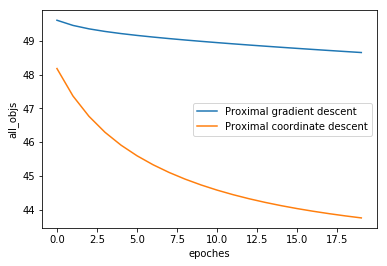

In [17]:
x_axis = range(20)
plt.plot(x_axis, all_objs_log_gd, label = 'Proximal gradient descent')
plt.plot(x_axis, all_objs_log, label = 'Proximal coordinate descent')
plt.xlabel('epoches')
plt.ylabel('all_objs')
plt.legend()
plt.show()